<a href="https://colab.research.google.com/github/AshishGusain17/via_google_colab/blob/master/object_identify_among_chess_players.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import pandas as pd
import os,shutil,math,scipy,cv2
import numpy as np
import matplotlib.pyplot as plt
import random as rn
import imutils

from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,roc_curve,auc

from PIL import Image
from PIL import Image as pil_image
from PIL import ImageDraw

from time import time
from glob import glob
from tqdm import tqdm
from skimage.io import imread
from IPython.display import SVG
from skimage.transform import pyramid_gaussian

from scipy import misc,ndimage
from scipy.ndimage.interpolation import zoom
# from scipy.ndimage import imread

import keras
from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras import layers
from keras.preprocessing.image import save_img
from keras.utils.vis_utils import model_to_dot
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.models import Sequential,Input,Model
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

In [130]:
import h5py
# train = h5py.File('/content/drive/My Drive/rock_paper_scissors/train.h5', "r")
# test = h5py.File('/content/drive/My Drive/rock_paper_scissors/test.h5', "r")
# val = h5py.File('/content/drive/My Drive/rock_paper_scissors/vali.h5', "r")
chess = h5py.File('/content/drive/My Drive/chess_players/chess_players.h5', "r")
XX=chess["X"][:]
Z=chess["Z"][:]
print(np.array(chess))
num  = XX.shape[0] 
print(XX.shape,Z.shape)

# XX_train = train["X"][:]
# Z_train  =train["Z"][:]
# XX_test = test["X"][:]
# Z_test  =test["Z"][:]
# XX_val = val["X"][:]
# Z_val  = val["Z"][:]
# num_train , num_val = XX_train.shape[0] , XX_val.shape[0]
# print(XX_train.shape,Z_train.shape,XX_test.shape,Z_test.shape,XX_val.shape,Z_val.shape)

['X' 'Z']
(552, 224, 224, 3) (552,)


In [0]:
import imutils
 
def pyramid(image, scale=1.5, minSize=(30, 30)):
	# yield the original image
	yield image
 
	# keep looping over the pyramid
	while True:
		# compute the new dimensions of the image and resize it
		w = int(image.shape[1] / scale)
		image = imutils.resize(image, width=w)
 
		# if the resized image does not meet the supplied minimum
		# size, then stop constructing the pyramid
		if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
			break
 
		# yield the next image in the pyramid
		yield image

In [132]:
imgsize=300
img=XX_train[1]
for value in pyramid(img):  
    print(value.shape) 
# X=np.zeros((num,imgsize,imgsize,3))
# for ind in range(num):
#   img = cv2.resize(XX[ind].reshape(XX.shape[1],XX.shape[1],3),(imgsize,imgsize))
#   X[ind]=img
# print(X.shape)

(300, 300, 3)
(200, 200, 3)
(133, 133, 3)
(88, 88, 3)
(58, 58, 3)
(38, 38, 3)


(300, 300, 3)
(200, 200, 3)
(134, 134, 3)
(90, 90, 3)
(60, 60, 3)
(40, 40, 3)


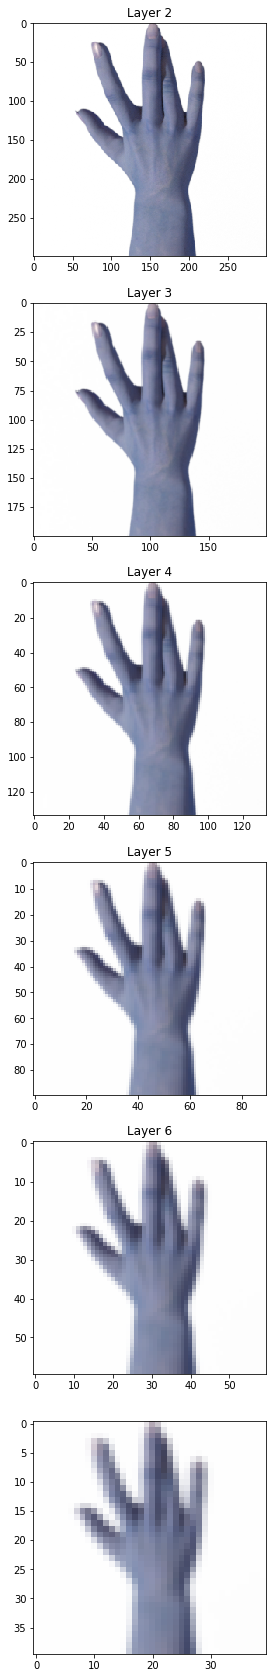

In [133]:
# METHOD #2: Resizing + Gaussian smoothing.
plt.figure(figsize=(30,30))
for (i, resized) in enumerate(pyramid_gaussian(img, downscale=1.5,multichannel=True)):
  if resized.shape[0]<30 or resized.shape[1]<30:
    break
  print(resized.shape)
  plt.title("Layer {}".format(i + 1))
  plt.subplot(6,1,i+1)
  plt.imshow( resized)

In [134]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

im = ct[6]

# Create figure and axes
fig,ax = plt.subplots(1)
# plt.subplot(3,3,1)
# Display the image
ax.imshow(im)

# Create a Rectangle patch
length,height=30,50
rect = patches.Rectangle((20,100),length,height,linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

TypeError: ignored

In [135]:
# label_encoder= LabelEncoder()
# Y = label_encoder.fit_transform(Z)
tr,va,te=Z_train,Z_val,Z_test
Z = to_categorical(Z,6)
X = XX/255

# print(X)
x_train,x_test,y_train,y_test = train_test_split(X,Z,test_size=0.2,random_state=42)
print(x_train.shape,y_train.shape)


(441, 224, 224, 3) (441, 6)


In [0]:
augs_gen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=20,  
        zoom_range = 0.1, 
        width_shift_range=0.2,  
        height_shift_range=0.2, 
        horizontal_flip=True,  
        vertical_flip=False) 

# augs_gen = ImageDataGenerator(vertical_flip=False) 
augs_gen.fit(x_train)

552


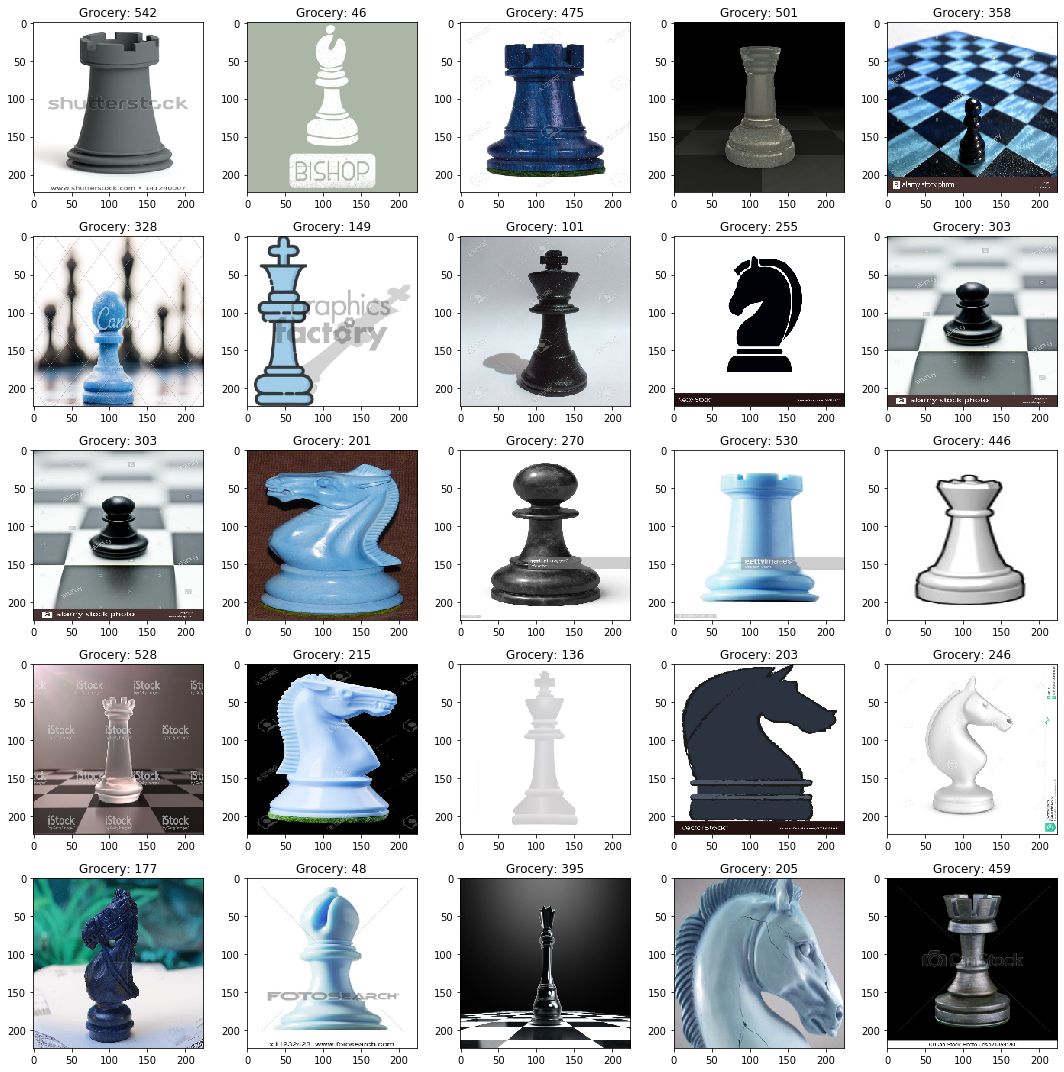

In [137]:
fig,ax=plt.subplots(5,5)
fig.set_size_inches(15,15)
print(len(Z))
for i in range(5):
    for j in range (5):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Grocery: '+ str(l))
        
plt.tight_layout()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

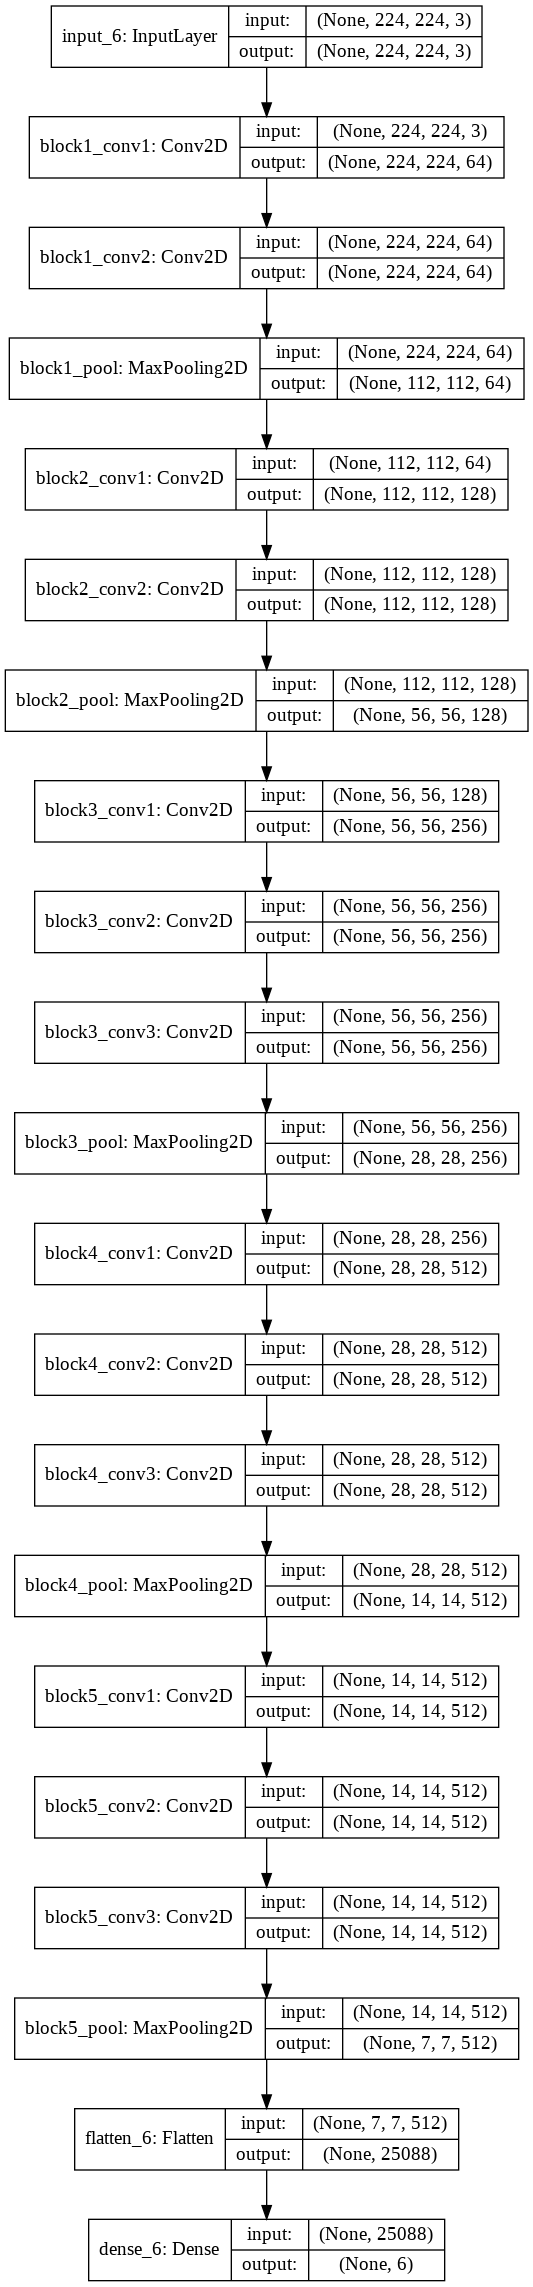

In [141]:
ct=0
imgsize=224
base_model = VGG16(include_top=False,
                  input_shape = (imgsize,imgsize,3),
                  weights = 'imagenet')
base_model.summary()
# base_model.layers.pop()
# base_model.layers.pop()
# base_model.layers.pop()


model = Sequential()
for layer in base_model.layers:
  model.add(layer)

for layer in base_model.layers:
  ct=ct+1

for layer in base_model.layers:
  if ct>0:
    layer.trainable = False
  else:
    layer.trainable = True
  ct=ct-1
  print(layer,layer.trainable)



# model.add(GlobalAveragePooling2D())
# model.add(Dropout(0.3))
model.add(Flatten())

# model.add(regularizers.l2(0.01))

model.add(Dense(6,activation='softmax'))
model.summary()

SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
checkpoint = ModelCheckpoint(
    './base.model',
    monitor='val_acc',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=30,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

# callbacks = [checkpoint,tensorboard,csvlogger,reduce]
callbacks = [earlystop,tensorboard,csvlogger,reduce]

In [143]:

opt = SGD(lr=1e-4,momentum=0.99)
opt1 = Adam(lr=1e-3)

model.compile(
    loss='categorical_crossentropy',
    optimizer=opt1,
    metrics=['accuracy']
)


history = model.fit(
    x_train,y_train,batch_size=32,
    validation_data  = (x_test,y_test),
    # validation_steps = 100,
    # steps_per_epoch  = 10,
    epochs = 18, 
    verbose = 1,
    callbacks=callbacks
)
# history = model.fit_generator(
#     augs_gen.flow(x_train,y_train,batch_size=32),
#     validation_data  = (x_test,y_test),
#     validation_steps = 100,
#     # steps_per_epoch  = 100,
#     epochs =5, 
#     verbose = 1,
#     callbacks=callbacks
# )

Train on 441 samples, validate on 111 samples
Epoch 1/18
441/441 [==============================] - 2s 4ms/step - loss: 1.8276 - acc: 0.3583 - val_loss: 1.1958 - val_acc: 0.6036
Epoch 2/18
441/441 [==============================] - 2s 4ms/step - loss: 0.5622 - acc: 0.8050 - val_loss: 0.9922 - val_acc: 0.6396
Epoch 3/18
441/441 [==============================] - 2s 4ms/step - loss: 0.2612 - acc: 0.9297 - val_loss: 0.7205 - val_acc: 0.7568
Epoch 4/18
441/441 [==============================] - 2s 4ms/step - loss: 0.1573 - acc: 0.9637 - val_loss: 0.6782 - val_acc: 0.7928
Epoch 5/18
441/441 [==============================] - 2s 4ms/step - loss: 0.1142 - acc: 0.9864 - val_loss: 0.6503 - val_acc: 0.8198
Epoch 6/18
441/441 [==============================] - 2s 4ms/step - loss: 0.0757 - acc: 0.9977 - val_loss: 0.7616 - val_acc: 0.7658
Epoch 7/18
441/441 [==============================] - 2s 4ms/step - loss: 0.0613 - acc: 0.9955 - val_loss: 0.6811 - val_acc: 0.8018
Epoch 8/18
441/441 [==========

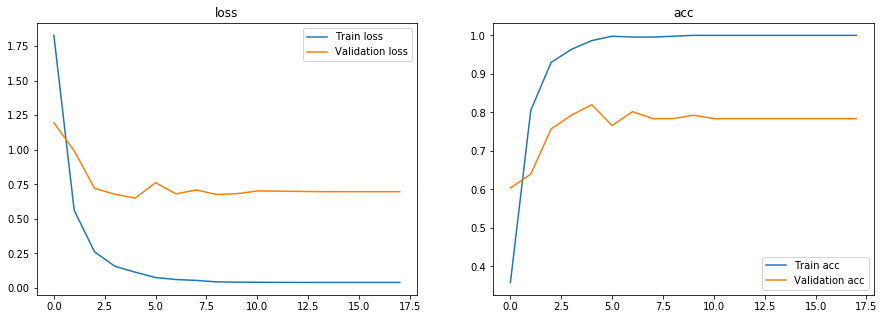

In [144]:
show_final_history(history)
# model.load_weights('./base.model')

# model_json = model.to_json()
# with open("model.json","w") as json_file:
#     json_file.write(model_json)
    
# model.save("model.h5")
# print("Weights Saved")

In [147]:
# use x 
a=model.evaluate(x_test,y_test)
b=model.evaluate(x_train,y_train)
print(a)
print(b)
ind=0

441/441 [==============================] - 1s 3ms/step
[0.6968705482311077, 0.7837837853947202]
[0.04019956992698365, 1.0]


[[9.6103925e-01 3.4524538e-02 4.2202370e-04 1.0134347e-03 2.9737852e-03
  2.6951710e-05]]
[[8.07738304e-01 1.66545168e-01 6.60856301e-03 5.37773641e-03
  1.35953035e-02 1.34922579e-04]]


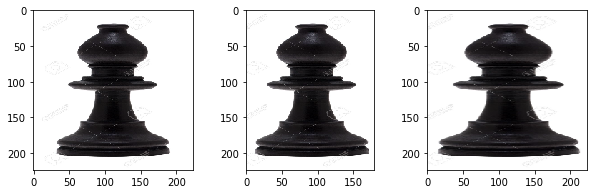

In [178]:
ind=9
a=model.predict(X[ind].reshape(1,224,224,3))
crop=X[ind][:,20:200]
img = cv2.resize(crop,(224,224))
b=model.predict(img.reshape(1,224,224,3))
print(a)
print(b)
plt.figure(figsize=(10,10))
plt.subplot(3,3,1)
plt.imshow(X[ind])
plt.subplot(3,3,2)
plt.imshow(crop)
plt.subplot(3,3,3)
plt.imshow(img)

[[0.83370763 0.05802175 0.00154227 0.04401827 0.06186086 0.00084911]]
[[8.4807247e-01 4.5423839e-02 2.6610636e-03 2.9050749e-02 7.4227646e-02
  5.6419417e-04]]
[[8.4807247e-01 4.5423839e-02 2.6610636e-03 2.9050749e-02 7.4227646e-02
  5.6419417e-04]]
[[8.4911555e-01 5.7123479e-02 6.0932622e-03 1.7105412e-02 7.0115007e-02
  4.4731249e-04]]
[[8.4911555e-01 5.7123479e-02 6.0932622e-03 1.7105412e-02 7.0115007e-02
  4.4731249e-04]]
[[8.8241804e-01 6.1538067e-02 2.1996228e-03 2.2761177e-03 5.1528607e-02
  3.9517196e-05]]


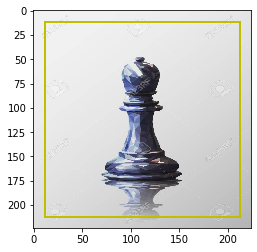

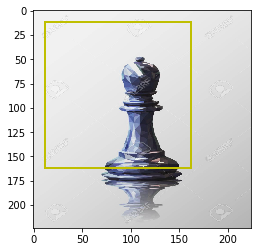

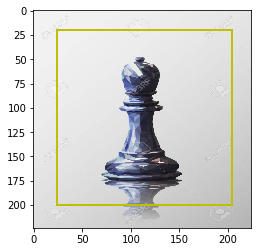

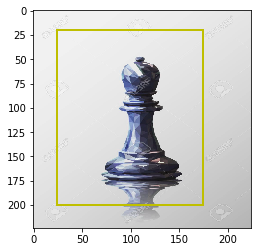

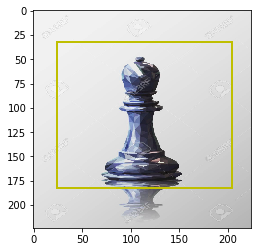

In [190]:
ind=19
b=model.predict(X[ind].reshape(1,224,224,3))
print(b)
indmax=np.argmax(b)
def sliding_window(image, stepSize, windowSize):
	# slide a window across the image
	for y in range(0, image.shape[0], stepSize):
		for x in range(0, image.shape[1], stepSize):
			# yield the current window
			yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])
   
max1 = 0
winW, winH = 80,80
diff_sizes=[(200,200),(150,150),(180,180),(150,180),(180,150)]
for size in diff_sizes:
  winW , winH= size[0],size[1]
  for (x, y, window) in sliding_window(X[ind], stepSize=4, windowSize=(winW, winH)):
    if window.shape[0] != winH or window.shape[1] != winW:
      continue
    img = cv2.resize(window,(224,224))
    pred=model.predict(img.reshape(1,224,224,3))
    if pred[0][indmax]>max1:
      max1=pred[0][indmax]
      x1,y1,window1=x,y,window
      b1=pred
  print(b1)

  # import matplotlib.patches as patches

  # Create figure and axes
  fig,ax = plt.subplots(1)
  # Display the image
  ax.imshow(X[ind])
  # Create a Rectangle patch
  length,height=winW, winH
  rect = patches.Rectangle((x1,y1),length,height,linewidth=2,edgecolor='y',facecolor='none')
  # Add the patch to the Axes
  ax.add_patch(rect)
plt.show()




(200, 200, 3)


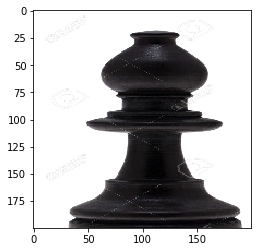

In [107]:
[0, 2, 68, 72, 78, 79, 81, 82, 84, 90, 108, 140, 149, 182, 302, 360, 363, 386, 396, 467, 479, 499, 528]
print(arg.shape)
plt.imshow(arg)